## [Chapter 13] Natural Language Autocomplete

In this notebook, we're going to use transformers to get autocomplete suggestions for a given term.

**NOTE**: This notebook depends upon the the Outdoors dataset. If you have any issues, please run the [Setting up the Outdoors Dataset](../ch13/1.ch13-setting-up-the-outdoors-dataset.ipynb) first to grab the dataset.

In [1]:
import sys
sys.path.append('..')
from aips import *

In [2]:
import pandas
import pickle
import json
import tqdm
pandas.set_option('display.max_rows', 1000)

## Load and clean the Outdoors dataset

In [3]:
from densevectors.outdoors import *
#Transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('../data/outdoors/posts.csv')
print(len(outdoors_dataframe))

19585


## Make a vocabulary of all the concepts in a corpus

In [4]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')

## Listing 13.9

In [5]:
def normalize(span):
    #normalizes a noun or verb phrase
    return ' '.join([tok.lemma_.lower() for tok in span])

def yieldTuple(df,column,total=100):
    #yields a spacy nlp.pipe compliant tuple of the column text values and its dataframe row as the context
    for idx,row in df.iterrows():
        if idx<total:
            yield (row[column],idx)

def getConcepts(df,total=None,load_from_cache=True):

    if load_from_cache:
        with open('../data/outdoors/outdoors_concepts.pickle','rb') as fd:
            concepts = pickle.load(fd)
        with open('../data/outdoors/outdoors_labels.pickle','rb') as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print('Extracting concepts. This could take a while. Take a break and stretch :)')
    
    #You can limit the number of rows processed by passing in total (an integer)
    if not total:
        total = len(df)
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ['NN','NNP','NNS','NOUN'] #Nouns
    verbtags = ['VB','VBD','VBG','VBN','VBP','VBZ','VERB'] #Verbs
    matcher.add("noun_phrases", [[{"TAG":{"IN": nountags}, "IS_ALPHA": True,"OP":"+"}]])
    matcher.add("verb_phrases", [[{"TAG":{"IN": verbtags}, "IS_ALPHA": True,"OP":"+", "LEMMA":{"NOT_IN":["be"]}}]])
    for doc,idx in tqdm.tqdm(nlp.pipe(yieldTuple(df,"body",total=total), batch_size=40, n_threads=4, as_tuples=True),total=total):
        text = doc.text
        matches = matcher(doc)
        for matchid,start,end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)
            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i in range(len(phrases)):
        phrase = phrases[i]
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    with open('../data/outdoors/outdoors_concepts.pickle','wb') as fd:
        pickle.dump(sorted_concepts,fd)
    with open('../data/outdoors/outdoors_labels.pickle','wb') as fd:
        pickle.dump(labels,fd)
    
    return sorted_concepts,labels

## Listing 13.10

### Examining the vocabulary

What are the concepts with the highest frequency?

In [6]:
# Set load_from_cache=False to re-extract all the concepts from the corpus.
concepts,labels = getConcepts(outdoors_dataframe,load_from_cache=True)
topcons = {k:v for (k,v) in concepts.items() if v>5 }
print('Total number of labels:',len(labels.keys()))
print('Total number of concepts:',len(concepts.keys()))
print('Concepts with greater than 5 term frequency:',len(topcons.keys()))
print(json.dumps(topcons,indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [7]:
from sentence_transformers import SentenceTransformer, util as STutil
stsb = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

## Listing 13.11

In [8]:
def getEmbeddings(concepts,minimum_frequency,load_from_cache=True):
    phrases = [key for (key,tf) in concepts.items() if tf>=minimum_frequency]
    if not load_from_cache:
        embeddings = stsb.encode(phrases, convert_to_tensor=True)
        with open('../data/outdoors/outdoors_embeddings.pickle','wb') as fd:
            pickle.dump(embeddings,fd)
    else:
        with open('../data/outdoors/outdoors_embeddings.pickle','rb') as fd:
            embeddings = pickle.load(fd)
    return phrases,embeddings

#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6

#set load_from_cache=False to regenerate the embeddings rather than loading from pickle
phrases,embeddings = getEmbeddings(concepts,minimum_frequency, load_from_cache=True)

print('Number of embeddings:',len(embeddings))
print('Dimensions per embedding:',len(embeddings[0]))

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.12

### Explore the top similarities for the top terms

In [9]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:250], embeddings[0:250])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(phrases[a])
        b_phrases.append(phrases[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"]>0.7]

,phrase a,phrase b,score,name,idx
0,protect,protection,0.928150,similarity,0
1,climbing,climber,0.923570,similarity,1
2,camp,camping,0.878894,similarity,2
3,climb,climbing,0.833662,similarity,3
4,something,someone,0.821081,similarity,4
5,hike,hiking,0.815187,similarity,5
6,people,person,0.784663,similarity,6
7,climb,climber,0.782961,similarity,7
8,go,leave,0.770643,similarity,8
9,keep,stay,0.768612,similarity,9


## Listing 13.13

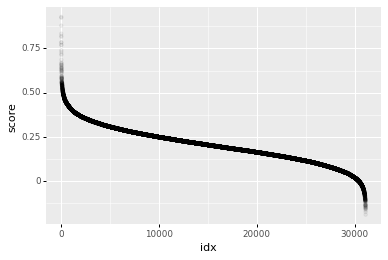

{<ggplot: (8728726145238)>}

In [10]:
from plotnine import *
#candidate_synonyms = comparisons[comparisons["score"]>0.0]
{
    ggplot(comparisons, aes('idx','score'))
    + geom_point(alpha = .05)
}

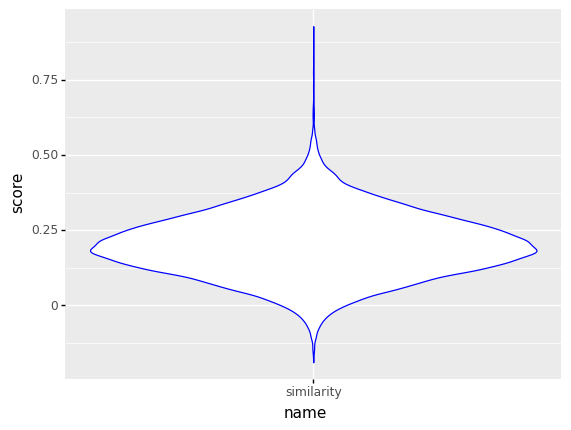

{<ggplot: (8783458304345)>}

In [45]:
#WARNING!  This produces a memory error on some Docker configurations and will reset the notebook kernel.
{
    ggplot(comparisons, aes('name','score')) +
    geom_violin(color='blue')
}

## Listing 13.14

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [11]:
import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


## Listing 13.15

In [12]:
from IPython.core.display import display,HTML
def print_labels(prefix,matches):
    display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
    for l,d in matches:
        if l in labels.keys():
            l = labels[l].lower()
        print(l + '\t' + str(d))
        
def semanticsuggest(query,k=20):
    matches = []
    embeddings = stsb.encode([query], convert_to_tensor=True)
    ids, distances = index.knnQuery(embeddings[0], k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.75:
            matches.append((text,dist))
    if not len(matches):
        matches.append((phrases[ids[1]],1.0-distances[1]))
    return matches

def autocomplete(prefix):
    matches = semanticsuggest(prefix)
    print_labels(prefix,matches)

In [13]:
autocomplete('mountain hike')

mountain hike	1.0
mountain hiking	0.9756487011909485
mountain trail	0.8470596075057983
mountain guides	0.7870420217514038
mountain terrain	0.7799178957939148
mountain climbing	0.7756214737892151
mountain ridge	0.7680721282958984
winter hikes	0.7541308403015137


In [14]:
autocomplete('campfire')

campfire	0.9999998211860657
camp fire	0.9566245675086975
campfire impacts	0.9282975792884827
camping fuels	0.8655521869659424
camping stoves	0.8239544034004211
camp stove	0.7969685196876526
cooking fires	0.7753304839134216
campground	0.774445116519928
fireplace	0.7649711966514587
camping area	0.7596509456634521
have camped	0.755319356918335


In [15]:
autocomplete('dehyd')

dehydrated	0.9417487382888794
dehydration	0.9317409992218018
rehydration	0.8525171279907227
dehydrator	0.8514857292175293
hydration	0.8362186551094055
hydrating	0.8358256816864014
rehydrating	0.8222475051879883
hydrated	0.8123505115509033
hydration pack	0.7883821725845337
hydration system	0.7768828272819519


In [16]:
autocomplete('compa')

comp	0.8632742166519165
compact	0.8295658230781555
compiled	0.8032786250114441
compost	0.7929491996765137
compass	0.7862531542778015
competitors	0.778240978717804
competence	0.7651968002319336
compactor	0.758799135684967
compare	0.7551056742668152


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [17]:
def buildCandidateSet(cons):
    terms = [k for (k,v) in cons.items()]
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = semanticsuggest(term,k=25)
        originals += [term]*len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({'term':originals,'candidate':candidates,'score':scores})
    return pairs

In [ ]:
pairs = buildCandidateSet(topcons)
pairs.to_csv('../data/outdoors/pairs.csv')

In [20]:
#Compare a list of terms
def compare(terms):

    term_embeddings = stsb.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms)-1):
        for b in range(a+1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = STutil.pytorch_cos_sim(term_embeddings[a],term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [21]:
#Gender-occupational bias
compare(['man','woman','nurse practitioner','doctor'])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Vector Space Visualization
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

/tmp/ipykernel_2044/2127518869.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


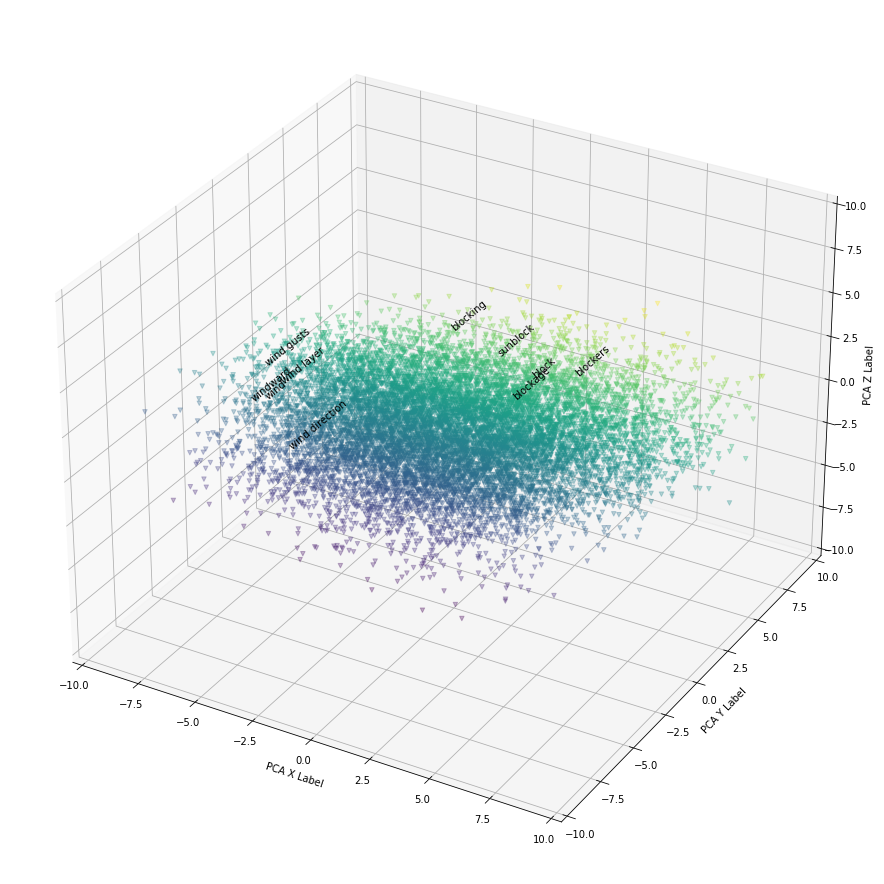

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pandas.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection='3d')
ax.scatter(
    components['x'].values, 
    components['y'].values, 
    c=components['y'].values, 
    marker='v', 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()

## Success!

Natural Language Autocomplete is a powerful feature, but we can use the same vector search technique on our main search results, as well, which we'll explore in the next notebook.

Up next: [Semantic Search with Transformers](4.ch13-semantic-search.ipynb). 